In [ ]:
!pip install nengo==3.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
!pip install nengo-dl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nengo-dl: filename=nengo_dl-3.6.0-py3-none-any.whl size=204184 sha256=249fdf051e90a6617220f330281a4a2b9b2443c43b6384a8816608ca1f23d8be
  Stored in directory: /root/.cache/pip/wheels/99/98/1a/c238f79c953dec26b4345dc4aa1a9b7b0b250bac1018985465
Successfully built nengo-dl


In [ ]:
import pickle
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import BatchNormalization
from keras.initializers import glorot_uniform
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from keras import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython import display
from keras.regularizers import l2
from keras.initializers import HeNormal
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

In [ ]:
import nengo

In [ ]:
!pip install tensorflow==2.10.0

In [ ]:
import nengo_dl

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Nengo version:", nengo.__version__)
print("NengoDL version:", nengo_dl.__version__)

TensorFlow version: 2.10.0
Nengo version: 3.2.0
NengoDL version: 3.6.0


In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/FingerClassification/Data/data_final1.pkl")

In [ ]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Bước 1: Làm phẳng mỗi mảng 2 chiều và tạo mảng 2 chiều cho việc scale
df = df.sort_values(by='Timestamp', ascending=True)

le = LabelEncoder()

# Phân chia người tham gia
# Đặt những người tham gia vào tập kiểm tra
split_factor = 0.8
ptcp_train = df.Participant.unique()[:math.floor(len(df.Participant.unique())*split_factor)]
ptcp_test = df.Participant.unique()[math.floor(len(df.Participant.unique())*split_factor):]
df_train = df[df.Participant.isin(ptcp_train)].copy(deep=True)
df_test = df[df.Participant.isin(ptcp_test)].copy(deep=True)

X_train = np.stack(df_train['Resized_Blobs'].values)
X_test = np.stack(df_test['Resized_Blobs'].values)

y_train = df_train['Handedness'].values
y_test = df_test['Handedness'].values

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
y_train

In [ ]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
# flatten images and add time dimension
train_images1 = train_images.reshape((train_images.shape[0], 1, -1))
train_labels1 = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images1 = test_images.reshape((test_images.shape[0], 1, -1))
test_labels1 = test_labels.reshape((test_labels.shape[0], 1, -1))
print(train_images1.shape, train_labels1.shape, test_images1.shape, test_labels1.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 1, 784) (60000, 1, 1) (10000, 1, 784) (10000, 1, 1)


In [ ]:
X_train1 = X_train.reshape((X_train.shape[0], 1, -1))
y_train1 = y_train.reshape((y_train.shape[0], 1, -1))
X_test1 = X_test.reshape((X_test.shape[0], 1, -1))
y_test1 = y_test.reshape((y_test.shape[0], 1, -1))

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)

(75744, 8, 8) (75744,) (19827, 8, 8) (19827,)
(75744, 1, 64) (75744, 1, 1) (19827, 1, 64) (19827, 1, 1)


In [ ]:
inp = tf.keras.Input(shape=(8,8,1))

# convolutional layers
conv0 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation=tf.nn.relu,
)(inp)

conv1 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
)(conv0)

# fully connected layer
flatten = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(units=2)(flatten)

model = tf.keras.Model(inputs=inp, outputs=dense)

In [ ]:
# Chuyển đổi mô hình thành mạng Nengo
converter = nengo_dl.Converter(model)

In [ ]:
from urllib.request import urlretrieve

In [ ]:
do_training = True
if do_training:
    with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
        # run training
        sim.compile(
            optimizer=tf.optimizers.Adam(0.001),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.sparse_categorical_accuracy],
        )
        sim.fit(
            {converter.inputs[inp]: X_train1},
            {converter.outputs[dense]: y_train1},
            validation_data=(
                {converter.inputs[inp]: X_test1},
                {converter.outputs[dense]: y_test1},
            ),
            epochs=1,
        )

        # save the parameters to file
        sim.save_params("./keras_to_snn_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1lBkR968AQo__t8sMMeDYGTQpBJZIs2_T",
        "keras_to_snn_params.npz",
    )
    print("Loaded pretrained weights")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|#                        Constructing graph                          | 0:00:00

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Construction finished in 0:00:00                                               


/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (19827) is not evenly divisible by Simulator.minibatch_size (200); input data will be truncated.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (75744) is not evenly divisible by Simulator.minibatch_size (200); input data will be truncated.
  warnings.warn(


378/378 [==============================] - 36s 84ms/step - loss: 0.6591 - probe_loss: 0.6591 - probe_sparse_categorical_accuracy: 0.5958 - val_loss: 0.6719 - val_probe_loss: 0.6719 - val_probe_sparse_categorical_accuracy: 0.5905


In [ ]:
def run_network(
    activation,
    params_file="keras_to_snn_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.linspace(
        0,
        np.prod(conv0.shape[1:]),
        1000,
        endpoint=False,
        dtype=np.int32,
    )
    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[conv0][sample_neurons])

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(X_test1[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == y_test1[:n_test, 0, 0]).mean()
    print(f"Test accuracy: {100 * accuracy:.2f}%")

    # plot the results
    for ii in range(3):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(X_test1[ii, 0].reshape((8, 8)), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        scaled_data = data[conv0_probe][ii] * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel("Number of spikes")
        else:
            rates = scaled_data
            plt.ylabel("Firing rates (Hz)")
        plt.xlabel("Timestep")
        plt.title(
            f"Neural activities (conv0 mean={rates.mean():.1f} Hz, "
            f"max={rates.max():.1f} Hz)"
        )
        plt.plot(scaled_data)

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][ii]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()

In [ ]:
run_network(activation=nengo.RectifiedLinear(), n_steps=10)

40/40 [==============================] - 3s 64ms/step
Test accuracy: 92.75%


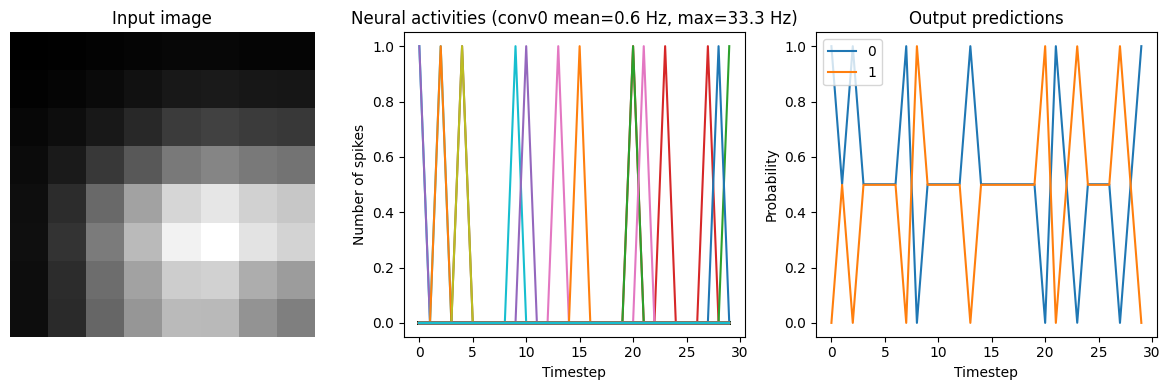

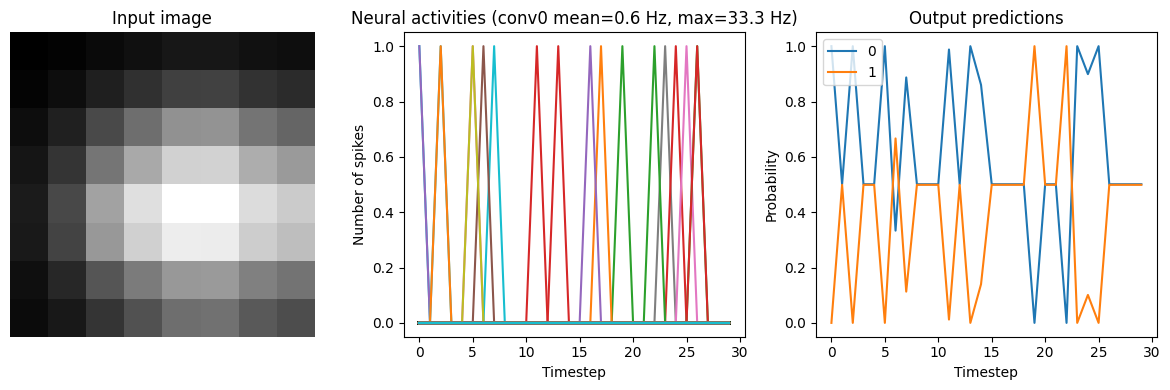

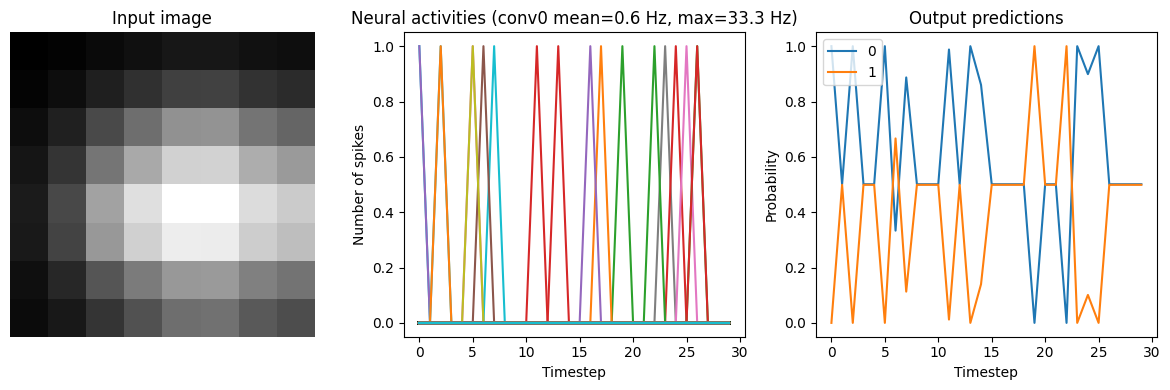

In [ ]:
run_network(activation=nengo.SpikingRectifiedLinear())